In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-18 16:24:15.240120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 16:24:15.244133: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 16:24:15.255525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752848655.274009  719254 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752848655.279556  719254 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-18 16:24:15.299279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

model = load_model("../models/MinimlModel.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

2025-07-18 16:24:18.178499: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9523 - loss: 0.1364
Test Accuracy: 0.9589
Test Loss: 0.1182


In [4]:
test_gen.set_Mode_To_Rescale(rescale=True, source="CIFAR-10")
test_loss_rescale, test_acc_rescale = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc_rescale:.4f}")
print(f"Test Loss: {test_loss_rescale:.4f}")
test_gen.set_Mode_To_Rescale(rescale=False)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9678 - loss: 0.0924
Test Accuracy: 0.9689
Test Loss: 0.0863


In [5]:
# Shuffle needs to be off for this to make sense. Shuffling can be done by hand with test_gen.shuffle_indexes()

test_gen.shuffle_indexes()
y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)

test_gen.set_Mode_To_Rescale(rescale=True, source="CIFAR-10")
y_pred_rescaled = model.predict(test_gen)
test_gen.set_Mode_To_Rescale(rescale=False)

y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_pred_binary_rescaled = (y_pred_rescaled > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [6]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 68580 predictions greater then 0.5

67453 predictions are greater then 0.6
That is 98.4 percent of all predictions greater then 0.5

65927 predictions are greater then 0.7
That is 96.1 percent of all predictions greater then 0.5

63667 predictions are greater then 0.8
That is 92.8 percent of all predictions greater then 0.5

59386 predictions are greater then 0.9
That is 86.6 percent of all predictions greater then 0.5

55172 predictions are greater then 0.95
That is 80.4 percent of all predictions greater then 0.5

49241 predictions are greater then 0.98
That is 71.8 percent of all predictions greater then 0.5


In [7]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 21420 predictions less then 0.5

20380 predictions are smaller then 0.4
That is 95.1 percent of all predictions smaller then 0.5

19399 predictions are smaller then 0.3
That is 90.6 percent of all predictions smaller then 0.5

18169 predictions are smaller then 0.2
That is 84.8 percent of all predictions smaller then 0.5

16360 predictions are smaller then 0.1
That is 76.4 percent of all predictions smaller then 0.5

14547 predictions are smaller then 0.05
That is 67.9 percent of all predictions smaller then 0.5

11869 predictions are smaller then 0.02
That is 55.4 percent of all predictions smaller then 0.5


In [8]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.88      0.94      0.91     20000
    ImageNet       0.98      0.96      0.97     70000

    accuracy                           0.96     90000
   macro avg       0.93      0.95      0.94     90000
weighted avg       0.96      0.96      0.96     90000



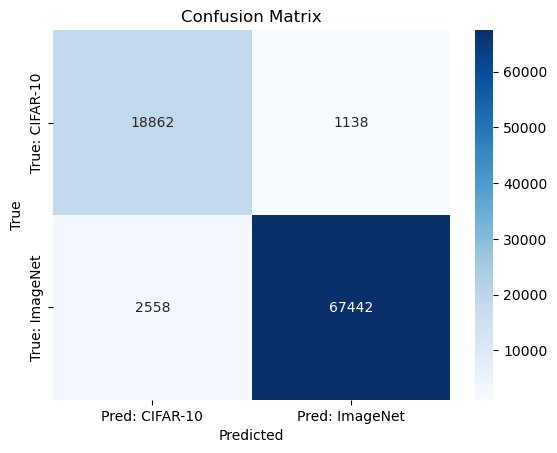

In [9]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

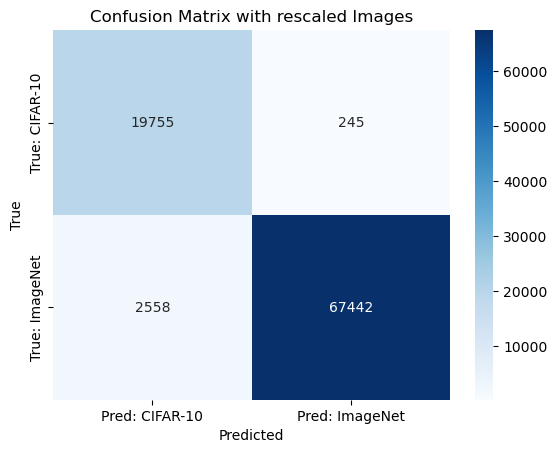

In [10]:
cm = confusion_matrix(y_true, y_pred_binary_rescaled)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix with rescaled Images")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
indexes = test_gen.return_Indexes()
categories = test_gen.return_Category_by_Index(indexes)

In [12]:
# Build the DataFrame
df_images = pd.DataFrame({
    "index": indexes,
    "category": categories,
    "y_true": y_true,
    "prediction": y_pred.flatten(),
    "rescaled_prediction": y_pred_rescaled.flatten() 
})

In [13]:
df_cifar = df_images[df_images["y_true"] == 0].copy()
df_imagenet = df_images[df_images["y_true"] == 1].copy()

In [14]:
print(f"CIFAR-10: {len(df_cifar)} images")
print(f"ImageNet: {len(df_imagenet)} images")

print(df_cifar.head())
print(df_imagenet.head())

CIFAR-10: 20000 images
ImageNet: 70000 images
    index  category  y_true  prediction  rescaled_prediction
1   72169      ship       0    0.199577             0.256158
3   55716      frog       0    0.003731             0.002906
8     758  airplane       0    0.329242             0.003316
17     70  airplane       0    0.000594             0.000706
20  19655      bird       0    0.001648             0.001907
   index category  y_true  prediction  rescaled_prediction
0  34314      cat       1    0.995932             0.995932
2  66900    horse       1    0.991280             0.991280
4  26272     bird       1    0.993536             0.993536
5  30426      cat       1    0.755152             0.755152
6  24405     bird       1    0.998685             0.998685


In [15]:
print(np.unique(df_images["category"]))

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [16]:
def from_DataFrame_get_subDataFrame_of_category(df, category):
    return df[df["category"] == category]

Loading images: 100%|████████████████████████████████| 8/8 [00:00<00:00, 1470.27it/s]


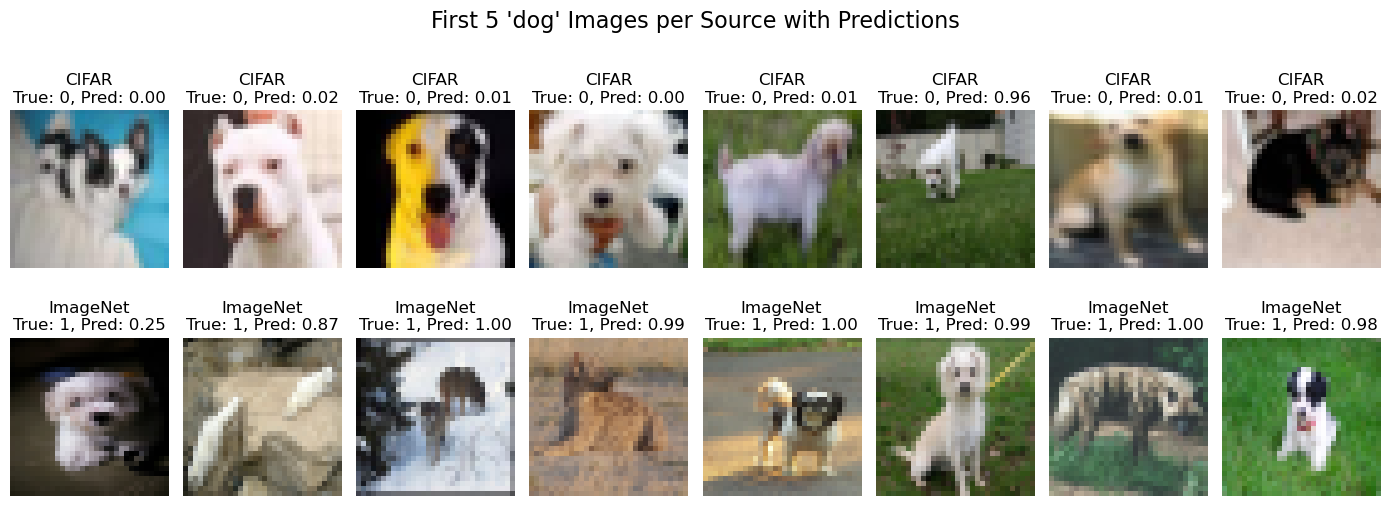

In [17]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 32
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar])
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet])

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[start_idx_cifar+i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[start_idx_imagenet+i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

Loading images: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 676.68it/s]


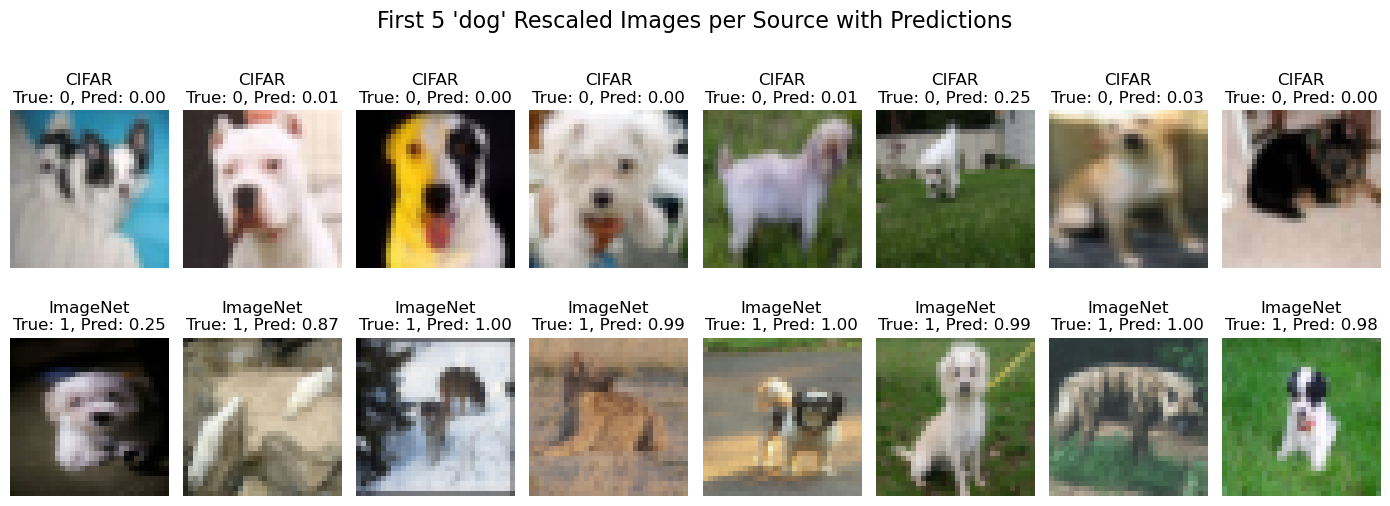

In [18]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 32
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar], rescaled=True)
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet], rescaled=True)

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[start_idx_cifar+i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['rescaled_prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[start_idx_imagenet+i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['rescaled_prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Rescaled Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,523 (5.95 KB)

 Trainable params: 507 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,016 (3.97 KB)

In [20]:
def visualize_activations(model, image, max_filters=6):
    """
    Visualize intermediate activations after each layer for a single image.

    Parameters:
    - model: Trained Keras model
    - image: Numpy array of shape (32, 32, 3)
    - max_filters: How many filters to display per conv layer
    """
    # Show original image
    fig, axs = plt.subplots(1, 4, figsize=(4 * 2.5, 2.5))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    for i in range(3):
        axs[i+1].imshow(image[:,:,i])
        axs[i+1].set_title(f"Original Image Channel {i+1}")
        axs[i+1].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Prepare image as batch input
    img_input = np.expand_dims(image, axis=0)

    # Get intermediate outputs
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict(img_input)

    # Visualize outputs
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Conv/Pool layers: (1, H, W, C)
            num_filters = min(activation.shape[-1], max_filters)
            fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2.5, 2.5))
            for j in range(num_filters):
                axs[j].imshow(activation[0, :, :, j], cmap='viridis')
                axs[j].axis('off')
                axs[j].set_title(f"Filter {j + 1}")
            plt.suptitle(f"Layer {i}: {model.layers[i].name} → shape {activation.shape[1:]}", fontsize=12)
            plt.tight_layout()
            plt.show()
        elif len(activation.shape) == 2:  # Dense layer: (1, N)
            print(f"Layer {i}: {model.layers[i].name} → Dense output shape: {activation.shape}")
            print(f"Output values (first 10): {activation[0][:36]}")


In [21]:
layer = model.layers[0] # layer.name returns 'conv2d'

# Extract weights from the Conv2D layer
kernels, biases = layer.get_weights()  # shape: (3, 3, 3, num_filters) for a 3x3 RGB kernel, num_filters filters
print("Kernel shape:", kernels.shape)
print(layer.input)

Kernel shape: (3, 3, 3, 2)
<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>


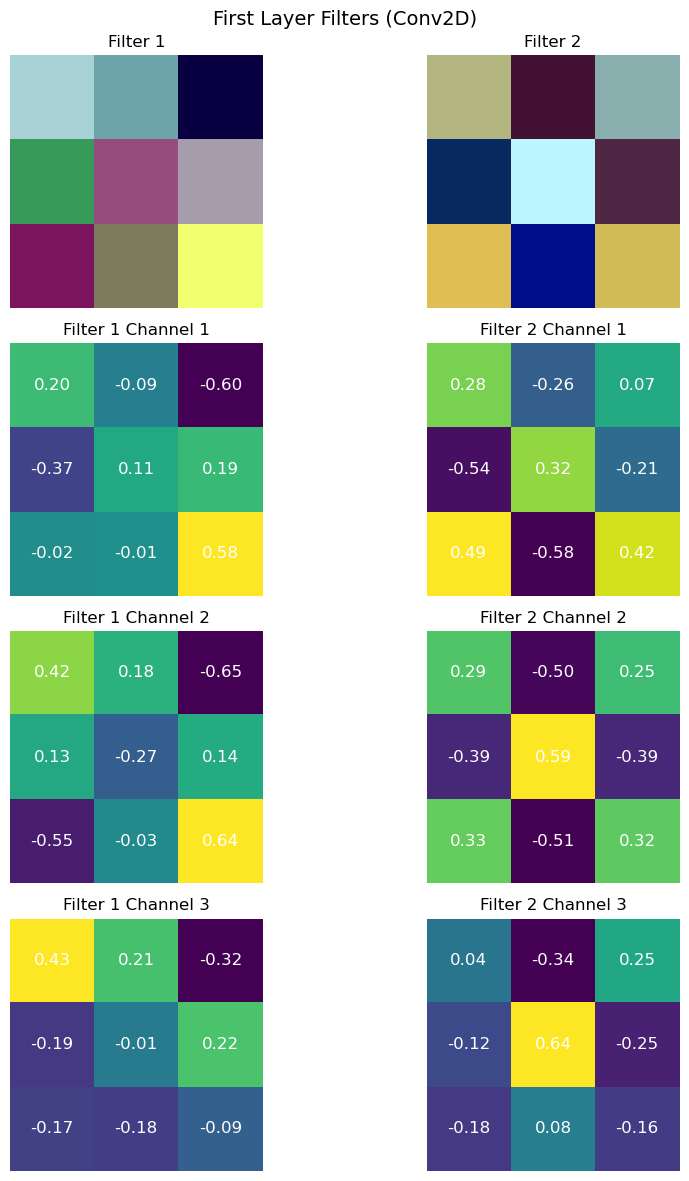

In [22]:
# Choose the first few filters
n_filters_to_show = np.min([5, kernels.shape[3]])
fig, axs = plt.subplots(4, n_filters_to_show, figsize=(5 * n_filters_to_show, 12))
axs = axs.flatten()

for i in range(n_filters_to_show):
    # Normalize for visualization
    kernel = kernels[:, :, :, i]
    kernel_min, kernel_max = kernel.min(), kernel.max()
    kernel_vis = (kernel - kernel_min) / (kernel_max - kernel_min)

    axs[i].imshow(kernel_vis)
    axs[i].set_title(f"Filter {i+1}")
    axs[i].axis('off')

    for j in range(3):
        kernel_channel_j = kernel[:,:,j]
        kernel_channel_j_min, kernel_channel_j_max = kernel_channel_j.min(), kernel_channel_j.max()
        kernel_vis_channel_j = (kernel_channel_j - kernel_channel_j_min) / (kernel_channel_j_max - kernel_channel_j_min)
        
        axs[i + n_filters_to_show * (j+1)].imshow(kernel_vis_channel_j)
        axs[i + n_filters_to_show * (j+1)].set_title(f"Filter {i+1} Channel {j+1}")
        axs[i + n_filters_to_show * (j+1)].axis('off')
        
        #for k in range(kernel_vis.shape[0]):
            #for z in range(kernel_vis.shape[1]):
               # axs[i + n_filters_to_show * (j+1)].text(z, k, f"{kernel_vis_channel_j[k, z]:.2f}",
                     #ha='center', va='center', color='white', fontsize=12)

        for k in range(kernel_vis.shape[0]):
            for z in range(kernel_vis.shape[1]):
                axs[i + n_filters_to_show * (j+1)].text(z, k, f"{kernel_channel_j[k, z]:.2f}",
                     ha='center', va='center', color='white', fontsize=12)

plt.suptitle("First Layer Filters (Conv2D)", fontsize=14)
plt.tight_layout()
plt.show()


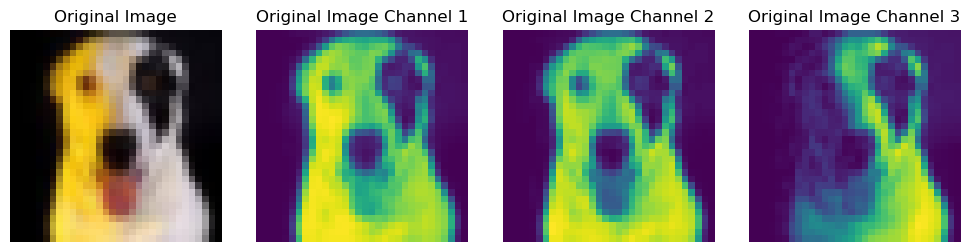

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


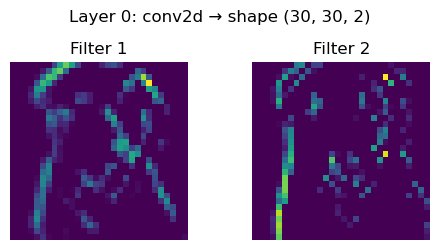

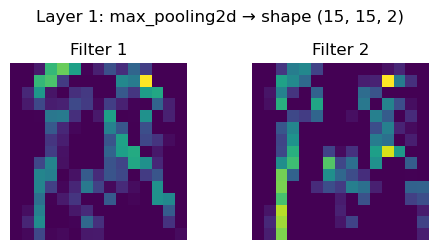

Layer 2: flatten → Dense output shape: (1, 450)
Output values (first 10): [0.         0.         0.         0.         0.06046803 0.02705055
 0.58459824 0.0728501  0.67578137 0.0808172  0.4991435  0.03446493
 0.00729029 0.         0.07777244 0.         0.21604943 0.
 0.11397155 0.         0.28709346 0.         0.1636365  0.00785905
 0.         0.01843124 0.         0.         0.         0.
 0.         0.         0.         0.         0.5853894  0.09835922]
Layer 3: dense → Dense output shape: (1, 1)
Output values (first 10): [0.00257366]


In [23]:
img = cifar_images[2]
visualize_activations(model, img, max_filters=5)

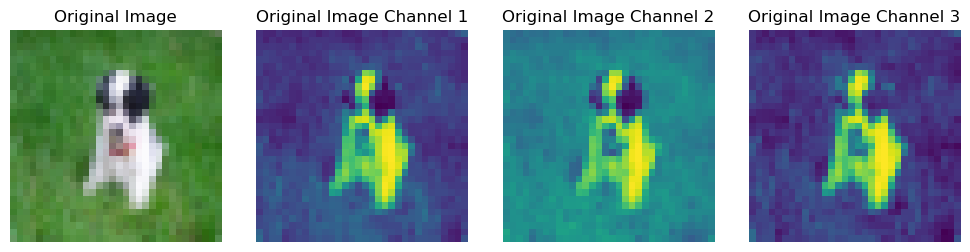

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


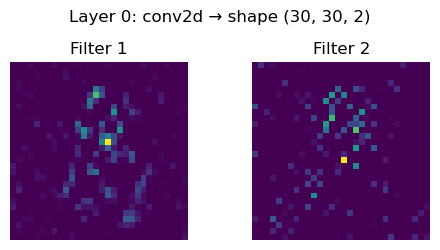

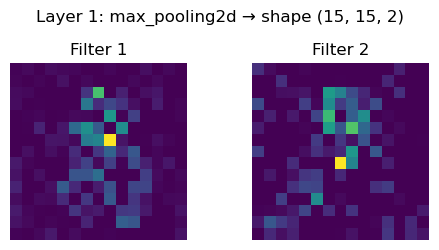

Layer 2: flatten → Dense output shape: (1, 450)
Output values (first 10): [0.01013572 0.0380129  0.03025077 0.00887686 0.         0.
 0.04152107 0.         0.02886218 0.00352925 0.02082118 0.
 0.         0.         0.         0.         0.0209979  0.
 0.         0.         0.         0.         0.04617345 0.
 0.         0.02493393 0.02441642 0.         0.         0.
 0.01905711 0.         0.         0.         0.01469126 0.03840055]
Layer 3: dense → Dense output shape: (1, 1)
Output values (first 10): [0.03518841]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.03518841]], dtype=float32)

In [24]:
img = imagenet_images[-1]
visualize_activations(model, img, max_filters=5)
model.predict(np.expand_dims(img, axis=0))